This notebook presents the key quality-control analyses used in the study. It loads the raw Xenium data and reports total transcript counts prior to H&E-based cell-segmentation refinement. It then quantifies the different artifact types, compares the number of cells removed before and after spatial filtering, and visualizes transcript and cell counts for each sample. To ensure reproducibility, the notebook also prints the numerical values reported in the paper and reproduces the key QC figures included in the study.

In [91]:
import pandas as pd
import os
import anndata as ad
import scanpy as sc
import json

import gzip
import numpy as np
from scipy.io import mmread
from tqdm import tqdm
import matplotlib.pyplot as plt
from venn import venn
import matplotlib.gridspec as gridspec
from collections import Counter

import sys
sys.path.append('..')
from configuration import STConfig
from wrappers.sdata_initalizer import SDataInitalizer
from wrappers.sdata_customizer import SDataCustomizer
config = STConfig()


### Reading Raw Data of Xenium Runs
Loading expression matrix of all samples in the cohort and show data stats

In [92]:
cfg = STConfig()
meta_df = pd.read_csv(cfg.pth_meta_csv)
samples = meta_df['sample_key'].tolist()

adata_list = []

for skey in tqdm(samples):
    customizer = SDataCustomizer(cfg, sample_key=skey)
    folder = os.path.join(customizer.base_path, customizer.exp_name, 'cell_feature_matrix')

    # Read matrix
    with gzip.open(f"{folder}/matrix.mtx.gz", "rb") as f:
        X = mmread(f).tocsr()

    # Read barcodes
    with gzip.open(f"{folder}/barcodes.tsv.gz", "rt") as f:
        barcodes = [line.strip() for line in f]

    # Read features
    with gzip.open(f"{folder}/features.tsv.gz", "rt") as f:
        features = [line.strip().split("\t")[1] for line in f]

    barcodes = [f'{skey}-{cid}' for cid in barcodes]
    # Create AnnData
    adata = ad.AnnData(X=X.T)
    adata.obs_names = barcodes
    adata.var_names = features
    adata_list.append(adata)
    
raw_adata = ad.concat(adata_list)

  0%|                                                                                                                                                                   | 0/32 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.32it/s]


In [93]:
## Total number of cells
print(f'Total number of cells: {raw_adata.n_obs}')

Total number of cells: 5780946


In [94]:
pth_gene_panel = customizer.base_path + '/' + customizer.exp_name + '/' + 'gene_panel.json'

In [95]:
with open(pth_gene_panel, "r") as f:
    gene_panel = json.load(f)

meta = gene_panel['payload']['targets']
meta

[{'codewords': [87],
  'info': {'gene_coverage': 4},
  'source': {'category': 'current',
   'identity': {'design_id': 'hMulti_v1',
    'name': 'Xenium Human Multi-Tissue and Cancer Gene Expression',
    'version': '1.0.0'}},
  'type': {'data': {'id': 'ENSG00000121270', 'name': 'ABCC11'},
   'descriptor': 'gene'}},
 {'codewords': [31],
  'info': {'gene_coverage': 8},
  'source': {'category': 'current',
   'identity': {'design_id': 'hMulti_v1',
    'name': 'Xenium Human Multi-Tissue and Cancer Gene Expression',
    'version': '1.0.0'}},
  'type': {'data': {'id': 'ENSG00000130234', 'name': 'ACE2'},
   'descriptor': 'gene'}},
 {'codewords': [349],
  'info': {'gene_coverage': 8},
  'source': {'category': 'current',
   'identity': {'design_id': 'hMulti_v1',
    'name': 'Xenium Human Multi-Tissue and Cancer Gene Expression',
    'version': '1.0.0'}},
  'type': {'data': {'id': 'ENSG00000213088', 'name': 'ACKR1'},
   'descriptor': 'gene'}},
 {'codewords': [342],
  'info': {'gene_coverage': 4},


Loading set of genes in the panel

In [96]:
dd = []
for idx in range(len(meta)):
    codeword = meta[idx]['type']
    if codeword['descriptor'] == 'gene':
        dd.append(codeword['data'])
genes_df = pd.DataFrame.from_dict(dd)

print(f'Total number of genes in the panel: {genes_df.shape[0]}')
genes_df.head(5)


Total number of genes in the panel: 377


,id,name
0,ENSG00000121270,ABCC11
1,ENSG00000130234,ACE2
2,ENSG00000213088,ACKR1
3,ENSG00000107796,ACTA2
4,ENSG00000163017,ACTG2


In [97]:
raw_adata = raw_adata[:, genes_df['name'].tolist()]
raw_adata

View of AnnData object with n_obs × n_vars = 5780946 × 377

### Loading processed adata object 

We are loading adata object we obtained after adding H&E based megakaryocyte detections adipocytes etc obtained in data_preparation step. 

In [98]:
adata_processed = ad.read_h5ad(config.pth_consol_adata)

# Computing per cell transcript counts
transcripts_per_cell =adata_processed.X.sum(1).A.ravel()
adata_processed.obs['transcripts_per_cell'] = transcripts_per_cell
adata_processed

AnnData object with n_obs × n_vars = 5843348 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'nearest_bone', 'distance_to_bone', 'bone_region', 'nearest_niche', 'distance_to_niche', 'obj.cell_id', 'obj.august_clusters_1', 'obj.anno_1', 'obj.anno_2', 'obj.anno_3', 'obj.anno_4', 'obj.anno_5', 'obj.anno_1_w_megs', 'obj.anno_2_w_megs', 'obj.anno_3_w_megs', 'obj.anno_4_w_megs', 'obj.anno_5_w_megs', 'extra_new_cell_status', 'batch', 'transcripts_per_cell'
    obsm: 'spatial'

In [99]:
# copying meta to a new dataframe for further analysis
df = adata_processed.obs.copy()

# restrict to non-adipocyte cells
mask = df['cell_status'] == 'adipocyte'
print(f"# of adipocytic cells {sum(mask)}")
df = df[~mask]
print(f"# of non-adipocytic cells including artefacts and H&E Megs {df.shape[0]}")

# for the rest of analysis we ignore adipocytes
adata_processed = adata_processed[~mask,:]

# of adipocytic cells 66536
# of non-adipocytic cells including artefacts and H&E Megs 5776812


In [100]:
adata_processed.n_obs

5776812

In [101]:
df['extra_new_cell_status'].value_counts()

extra_new_cell_status
original                    5711721
artefact                      27449
altered_with_small_cells      22747
megakaryocyte                 14238
altered                         657
Name: count, dtype: int64

- original indicates cells whose cell boundaries are not changed and default xenium cell boundaries are used
- artefact are cells which are removed from analysis. Cell with no nuclei. 
- megakaryoctye indicates megs detected by the H&E AI-based algorithm
- altered_with_small_cells indicated nearby cells to a meg whose boundaries are changed
- altered indicates additional cells that are made. These are polygons with its own nucelus

For the analysis we used all cells except the ones labeled as artefact. 



In [102]:
# Optimised segmentation with H&E-based AI-detected megakaryocytes and arefact removal
print(sum(df['extra_new_cell_status'] != 'artefact'))

5749363


In [103]:
df = df[~df['extra_new_cell_status'].isin(['artefact'])]

### Spatial Filtering of Cells

Below we show number of cells that are retained after manual annotation. Expert pathologists examined H&E stained tissue sections and marked areas with artefacts and we removed cells falling into atefacts area from analysis. We retained a total of 5285236 as shown below. 

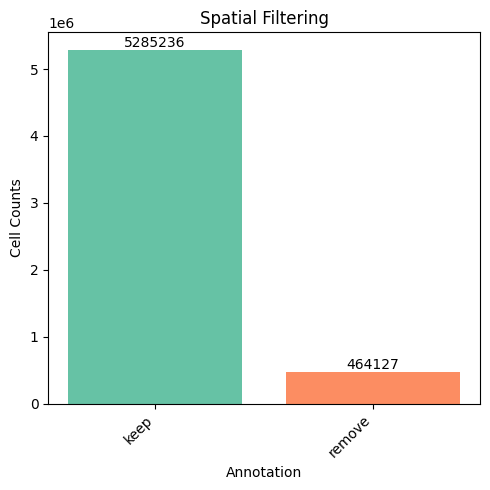

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns


counts = df['annotation'].value_counts()

fig, ax = plt.subplots(figsize=(5, 5))
colors = sns.color_palette("Set2", len(counts))
ax.bar(counts.index.astype(str), counts.values, color = colors)

ax.set_xlabel('Annotation')
ax.set_ylabel('Cell Counts')
ax.set_title('Spatial Filtering')

for i, v in enumerate(counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Filtering Cells based on Transcripts counts

In [105]:
df = df[df['annotation']=='keep']
adata_processed_filtered = adata_processed[df.index.tolist(), :].copy()
adata_processed_filtered

AnnData object with n_obs × n_vars = 5285236 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'nearest_bone', 'distance_to_bone', 'bone_region', 'nearest_niche', 'distance_to_niche', 'obj.cell_id', 'obj.august_clusters_1', 'obj.anno_1', 'obj.anno_2', 'obj.anno_3', 'obj.anno_4', 'obj.anno_5', 'obj.anno_1_w_megs', 'obj.anno_2_w_megs', 'obj.anno_3_w_megs', 'obj.anno_4_w_megs', 'obj.anno_5_w_megs', 'extra_new_cell_status', 'batch', 'transcripts_per_cell'
    obsm: 'spatial'

In [106]:
mask = df['transcripts_per_cell'] >=4
adata_final = adata_processed_filtered[mask, :].copy()
print("================================")
print(f'Number of cells with at least 4 transcripts: {sum(mask)}')
print("================================")
adata_final

Number of cells with at least 4 transcripts: 5104452


AnnData object with n_obs × n_vars = 5104452 × 377
    obs: 'region', 'slide', 'cell_id', 'area', 'cell_status', 'meg_phenotype', 'annotation', 'it_regions', 'mutation_status', 'run', 'study_id', 'diagnosis', 'diagnosis2', 'broad_diagnosis', 'SCT_snn_res.0.3', 'clusters', 'clusters_w_megs', 'new_clusters', 'new_clusters_w_megs', 'region_name', 'nearest_bone', 'distance_to_bone', 'bone_region', 'nearest_niche', 'distance_to_niche', 'obj.cell_id', 'obj.august_clusters_1', 'obj.anno_1', 'obj.anno_2', 'obj.anno_3', 'obj.anno_4', 'obj.anno_5', 'obj.anno_1_w_megs', 'obj.anno_2_w_megs', 'obj.anno_3_w_megs', 'obj.anno_4_w_megs', 'obj.anno_5_w_megs', 'extra_new_cell_status', 'batch', 'transcripts_per_cell'
    obsm: 'spatial'

Showing summary of the cells removed. 

<Figure size 800x800 with 0 Axes>

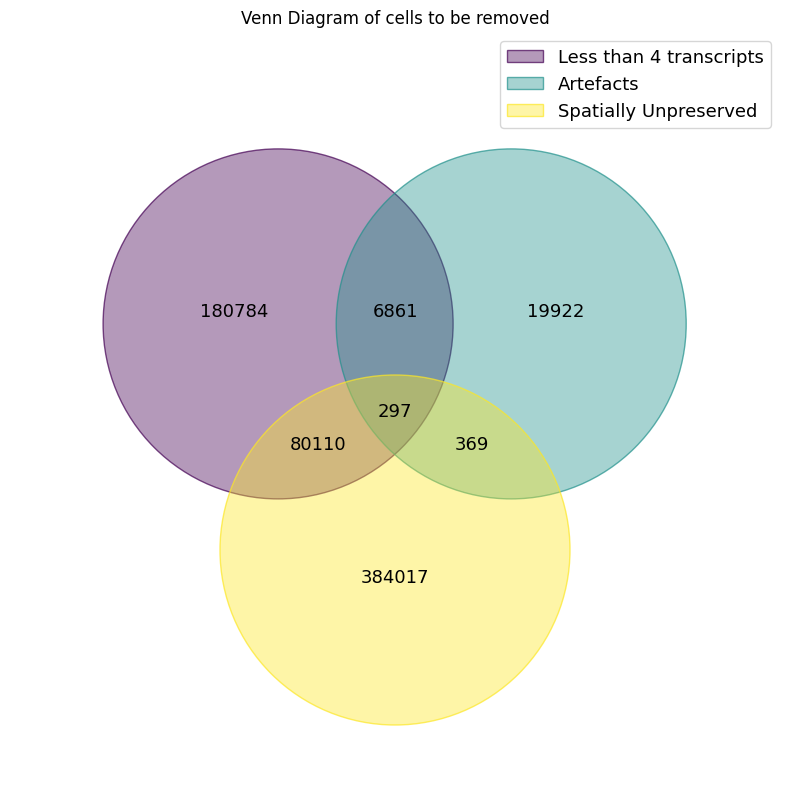

In [ ]:
df_proc_no_filter = adata_processed.obs.copy()
set_labels = {
    "Less than 4 transcripts": set(df_proc_no_filter[df_proc_no_filter['transcripts_per_cell'] < 4].index.tolist()),
    "Artefacts": set(df_proc_no_filter[df_proc_no_filter['extra_new_cell_status'] =='artefact'].index.tolist()),
    "Spatially Unpreserved": set(df_proc_no_filter[df_proc_no_filter["annotation"] == 'remove'].index.tolist())
}

plt.figure(figsize=(8, 8))
v = venn(set_labels)
plt.tight_layout()
plt.title("Venn Diagram of cells to be removed")
plt.show()

In [108]:
# Individual sizes
n_cell_transcripts   = len(set_labels["Less than 4 transcripts"])
n_cell_artefacts     = len(set_labels["Artefacts"])
n_cell_unpreserved   = len(set_labels["Spatially Unpreserved"])

union_set = (
    set_labels["Less than 4 transcripts"]
    | set_labels["Artefacts"]
    | set_labels["Spatially Unpreserved"]
)

# Cell counts no overlap
union_length = len(union_set)
# Sum of sizes (overcounts overlaps)
sum_lengths = n_cell_transcripts + n_cell_artefacts + n_cell_unpreserved

print("==========================================")

print("Less than 4 transcripts :", n_cell_transcripts)
print("Artefacts               :", n_cell_artefacts)
print("Spatially Unpreserved   :", n_cell_unpreserved)
print("\nSum of individual lengths (with overlap):", sum_lengths)
print("Union length (unique cells)           :", union_length)
# Remaining cells after removal
remaining = adata_processed.n_obs - union_length
print("\nFinal number of cells left:", remaining)
print("==========================================")


Less than 4 transcripts : 268052
Artefacts               : 27449
Spatially Unpreserved   : 464793

Sum of individual lengths (with overlap): 760294
Union length (unique cells)           : 672360

Final number of cells left: 5104452


### Showing Transcript per sample before and after preprocessing

In [125]:
skey = 'sample_id'
dkey = 'diagnosis2'
df_proc_no_filter[skey] = df_proc_no_filter['cell_id'].str[-8:]

df[skey] = df['cell_id'].str[-8:] # this is for the final filtered df used for analysis

diagnosis_order = ["Normal", "ET", "PV", "PrePMF", "MF"]
diagnosis_color_palette = ["limegreen", "deepskyblue", "red", "mediumorchid", "darkorange"]

In [110]:

def visualize_transcripts_per_sample(
        df,
        feature_col = 'transcripts_per_cell',
        dkey = 'diagnosis2',
        diagnosis_order =   ["Normal", "ET", "PV", "PrePMF", "MF"],
        diagnosis_color_palette = ["limegreen", "deepskyblue", "red", "mediumorchid", "darkorange"],
        skey = 'sample_id',
        title = "Transcript per cell per sample after preprocessing"
    ):
    
    df[dkey] = pd.Categorical(
    df[dkey],
    categories=diagnosis_order,
    ordered=True
    )

    df = df.sort_values(["diagnosis2", skey])
    
    plt.figure(figsize=(10, 8))

    sns.boxplot(
        data=df,
        y=skey,
        x=feature_col,
        hue='diagnosis2',
        hue_order=diagnosis_order, 
        palette= diagnosis_color_palette,
        showfliers=False
    )

    plt.title(title)
    plt.xlabel("Transcript Counts")
    plt.ylabel("Sample ID")
    plt.legend(title="Diagnosis")
    plt.tight_layout()
    plt.show()

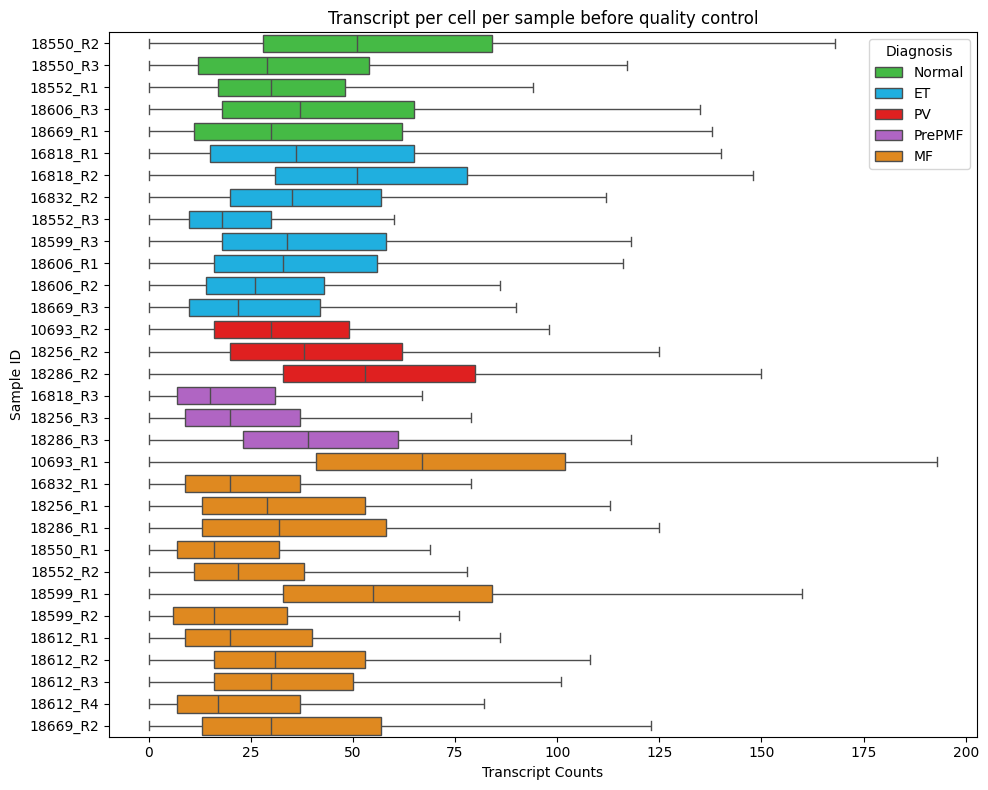

In [126]:
visualize_transcripts_per_sample(
    df=df_proc_no_filter,
    feature_col = 'transcripts_per_cell',
    title = "Transcript per cell per sample before quality control"
    )


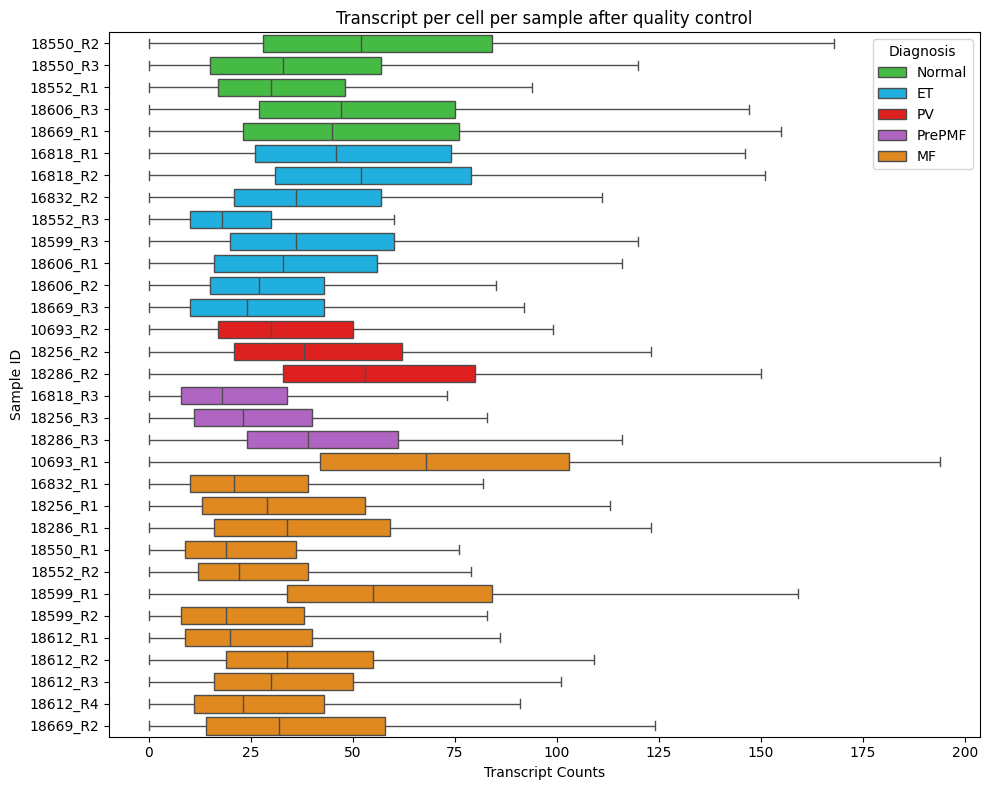

In [127]:
visualize_transcripts_per_sample(
    df=df,
    feature_col = 'transcripts_per_cell',
    title = "Transcript per cell per sample after quality control"
    )

### Plotting Proportion of cells (per sample) removed in Spatial & Transcript Filtering step

In [128]:
low_tc = df_proc_no_filter['transcripts_per_cell'] < 4
spat_unpreserved = df_proc_no_filter['annotation'] == 'remove'
df_qc = df_proc_no_filter[(low_tc | spat_unpreserved) * (df_proc_no_filter['extra_new_cell_status'] != 'artefact')].copy()

print('================================================')
print(f'Number of cells that with less than 4 transcripts or spatially unpreserved {df_qc.shape[0]}')
print('\n Unique cell statues')
print(df_qc['extra_new_cell_status'].unique())
print('\n entries in annotation columns')
print(df_qc['annotation'].unique(), '# of transcript', df_qc[df_qc['transcripts_per_cell']>=4].shape[0])
print('================================================')

Number of cells that with less than 4 transcripts or spatially unpreserved 644911

 Unique cell statues
['original', 'altered_with_small_cells', 'altered', 'megakaryocyte']
Categories (5, object): ['altered', 'altered_with_small_cells', 'artefact', 'megakaryocyte', 'original']

 entries in annotation columns
['keep', 'remove']
Categories (2, object): ['keep', 'remove'] # of transcript 384017


In [129]:
df_qc.loc[low_tc, 'label'] = 'less than 4 transcripts'
df_qc.loc[spat_unpreserved, 'label'] = 'cytomorphologically unpreserved'
df_qc.loc[low_tc*spat_unpreserved, 'label'] = 'both'
print(df_qc['label'].value_counts())

label
cytomorphologically unpreserved    384017
less than 4 transcripts            180784
both                                80110
Name: count, dtype: int64


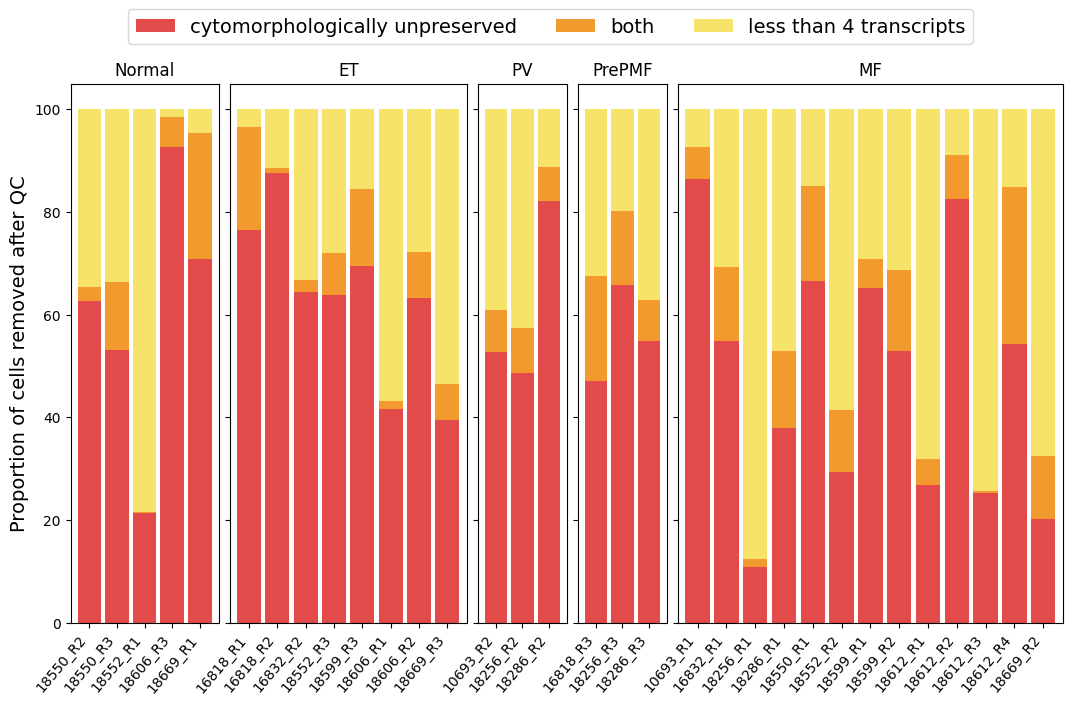

In [135]:
props = df_qc.groupby(skey)['label'].value_counts(normalize=True).reset_index()
map_dict = df_qc.set_index(skey)[dkey].to_dict()
props[dkey] = props[skey].map(map_dict)
props['proportion'] *= 100


counter = Counter(map_dict.values())
ordered_counts = {diag: counter[diag]/2.5 for diag in diagnosis_order}
widths = list(ordered_counts.values())

fig = plt.figure(figsize=(sum(widths), 7))
gs = gridspec.GridSpec(1, len(widths), width_ratios=widths)
gs.update(wspace=0.06)

color_dict = {
    "cytomorphologically unpreserved": "#e34a4a",
    "both": "#f29a2e",
     "less than 4 transcripts": "#f7e36a"
    
}

label_order = list(color_dict.keys())
first_ax = fig.add_subplot(gs[0, 0])

axes = [first_ax] + [fig.add_subplot(gs[0, i], sharey=first_ax) for i in range(1, len(widths))]


for idx, diag in enumerate(diagnosis_order):
    ax = axes[idx]

    sel_df = props[props[dkey] == diag]

    if sel_df.empty:
        ax.set_title(f"{diag}\n(no data)")
        ax.set_xticks([])
        continue

    pivot = sel_df.pivot_table(
        index=skey,
        columns='label',
        values='proportion',
        fill_value=0
        )
    pivot = pivot.reindex(columns=label_order)
    pivot.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        legend=False,
        color=[color_dict[c] for c in pivot.columns],
        width=0.85
        )

    ax.set_title(diag)
    ax.set_xlabel("")
    ax.set_ylim(0, 105)      
    ax.tick_params(axis='y', labelleft=(idx == 0))  # show y labels only on first panel
    ax.set_ylabel("Proportion of cells removed after QC" if idx == 0 else "", fontdict={'size':14})

    ax.set_xticklabels([str(x) for x in pivot.index], rotation=50, ha='right')

# single legend on top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(6, len(labels)), bbox_to_anchor=(0.5, 1), fontsize=14)
plt.savefig(f'/well/rittscher/users/qwi813/xenium_paper/outputs/figures/qc1.svg', bbox_inches='tight', dpi = 600)
plt.savefig(f'/well/rittscher/users/qwi813/xenium_paper/outputs/figures/qc1.png', bbox_inches='tight', dpi = 600)
plt.show()


In [132]:
df_qc2 = df_proc_no_filter[df_proc_no_filter['extra_new_cell_status'] != 'artefact'].copy()
df_qc2.loc[low_tc * spat_unpreserved, 'label'] = 'Unpreserved: less than 4 transcripts'
df_qc2.loc[low_tc * ~spat_unpreserved, 'label'] = 'Preserved: less than 4 transcripts'
df_qc2.loc[~low_tc * ~spat_unpreserved, 'label'] = 'Preserved: more than 3 transcripts'
df_qc2.loc[~low_tc * spat_unpreserved, 'label'] = 'Unpreserved: more than 3 transcripts'
df_qc2['label'].value_counts()

label
Preserved: more than 3 transcripts      5104452
Unpreserved: more than 3 transcripts     384017
Preserved: less than 4 transcripts       180784
Unpreserved: less than 4 transcripts      80110
Name: count, dtype: int64

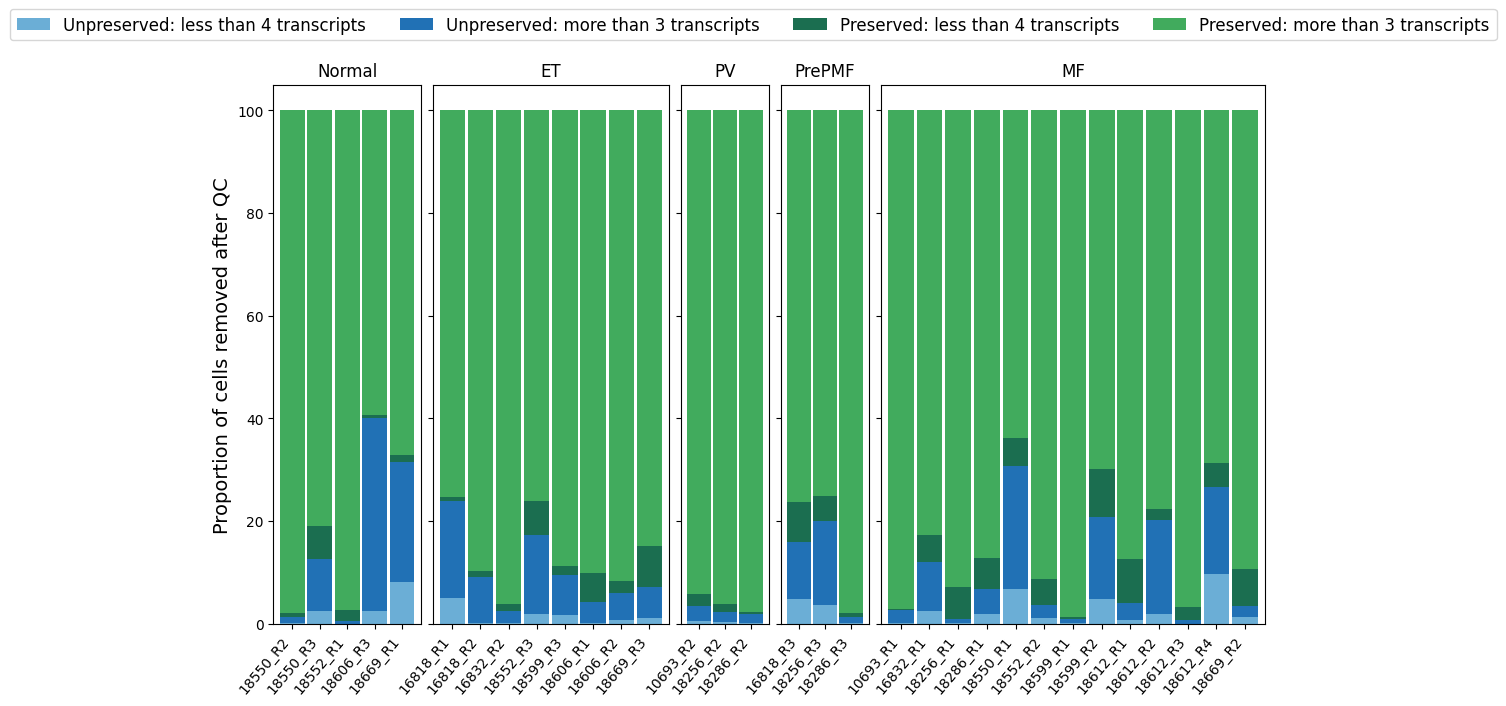

In [ ]:
props = df_qc2.groupby(skey)['label'].value_counts(normalize=True).reset_index()
map_dict = df_qc2.set_index(skey)[dkey].to_dict()
props[dkey] = props[skey].map(map_dict)
props['proportion'] *= 100


counter = Counter(map_dict.values())
ordered_counts = {diag: counter[diag]/2.5 for diag in diagnosis_order}
widths = list(ordered_counts.values())

fig = plt.figure(figsize=(sum(widths), 7))
gs = gridspec.GridSpec(1, len(widths), width_ratios=widths)
gs.update(wspace=0.06)

color_dict = {
    'Unpreserved: less than 4 transcripts': "#6BAED6",
    'Unpreserved: more than 3 transcripts': "#2171B5",
    'Preserved: less than 4 transcripts':"#1B6E50",
    'Preserved: more than 3 transcripts': "#41AB5D"
    
}

label_order = list(color_dict.keys())
first_ax = fig.add_subplot(gs[0, 0])

axes = [first_ax] + [fig.add_subplot(gs[0, i], sharey=first_ax) for i in range(1, len(widths))]


for idx, diag in enumerate(diagnosis_order):
    ax = axes[idx]

    sel_df = props[props[dkey] == diag]

    if sel_df.empty:
        ax.set_title(f"{diag}\n(no data)")
        ax.set_xticks([])
        continue

    pivot = sel_df.pivot_table(index=skey,
                               columns='label',
                               values='proportion',
                               fill_value=0)
    pivot = pivot.reindex(columns=label_order)
    pivot.plot(kind='bar',
               stacked=True,
               ax=ax,
               legend=False,
               color=[color_dict[c] for c in pivot.columns],
               width=0.9)

    ax.set_title(diag)
    ax.set_xlabel("")
    ax.set_ylim(0, 105)      
    ax.tick_params(axis='y', labelleft=(idx == 0))  # show y labels only on first panel
    ax.set_ylabel("Proportion of cells removed after QC" if idx == 0 else "", fontdict={'size':14})

    ax.set_xticklabels([str(x) for x in pivot.index], rotation=50, ha='right')

# single legend on top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=min(6, len(labels)), bbox_to_anchor=(0.5, 1), fontsize=12)
plt.show()
